In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Ridge
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import ta

# 1. Assessing the Influence of Economic Cycles on the VN-Index: A Comprehensive Analysis
# 1.1 Exploratory Data Analyst


# Vnindex

In [131]:
# Read VNINDEX data
# VNINDEX data
df_VNINDEX_raw= pd.read_csv(r"D:\HK5\STAT\Final\dataset\VNINDEX-2003-2023.csv")
# Rename columns
df_VNINDEX_raw=df_VNINDEX_raw.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_VNINDEX_raw['Date'] = pd.to_datetime(df_VNINDEX_raw['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_VNINDEX_raw['Close'] = pd.to_numeric(df_VNINDEX_raw['Close'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw['Open'] = pd.to_numeric(df_VNINDEX_raw['Open'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw['High'] = pd.to_numeric(df_VNINDEX_raw['High'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw['Low'] = pd.to_numeric(df_VNINDEX_raw['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_VNINDEX_raw['Change %'] = pd.to_numeric(
    df_VNINDEX_raw['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric
# Apply the conversion function to 'Volumne' column
df_VNINDEX_raw['Volumne'] = df_VNINDEX_raw['Volumne'].apply(convert_to_number)
df_VNINDEX_raw

,Date,Close,Open,High,Low,Volumne,Change %
0,2023-12-29,1129.93,1128.93,1135.05,1128.93,710850.0,0.09
1,2023-12-28,1128.93,1121.99,1130.58,1120.50,716930.0,0.62
2,2023-12-27,1121.99,1122.25,1126.47,1121.99,776800.0,-0.02
3,2023-12-26,1122.25,1117.66,1123.11,1117.66,644740.0,0.41
4,2023-12-25,1117.66,1103.06,1118.31,1103.06,658540.0,1.32
...,...,...,...,...,...,...,...
4983,2004-01-09,173.27,171.44,173.27,171.44,460.0,0.97
4984,2004-01-08,171.60,171.79,171.79,171.60,470.0,0.25
4985,2004-01-07,171.17,170.84,171.17,170.84,170.0,0.53
4986,2004-01-06,170.26,170.78,170.78,170.26,280.0,0.65


In [132]:
# Check basic infomation of data
print(df_VNINDEX_raw.info())

# Check null value
print(df_VNINDEX_raw.isnull().sum())

# Kiểm tra thống kê mô tả
print(df_VNINDEX_raw.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4988 non-null   datetime64[ns]
 1   Close     4988 non-null   float64       
 2   Open      4988 non-null   float64       
 3   High      4988 non-null   float64       
 4   Low       4988 non-null   float64       
 5   Volumne   4988 non-null   float64       
 6   Change %  4988 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 272.9 KB
None
Date        0
Close       0
Open        0
High        0
Low         0
Volumne     0
Change %    0
dtype: int64
             Close         Open         High          Low       Volumne  \
count  4988.000000  4988.000000  4988.000000  4988.000000  4.988000e+03   
mean    693.705012   693.847117   698.170162   689.153739  2.954937e+05   
std     325.714981   325.844137   328.023623   323.088587  3.354021e+06   
min

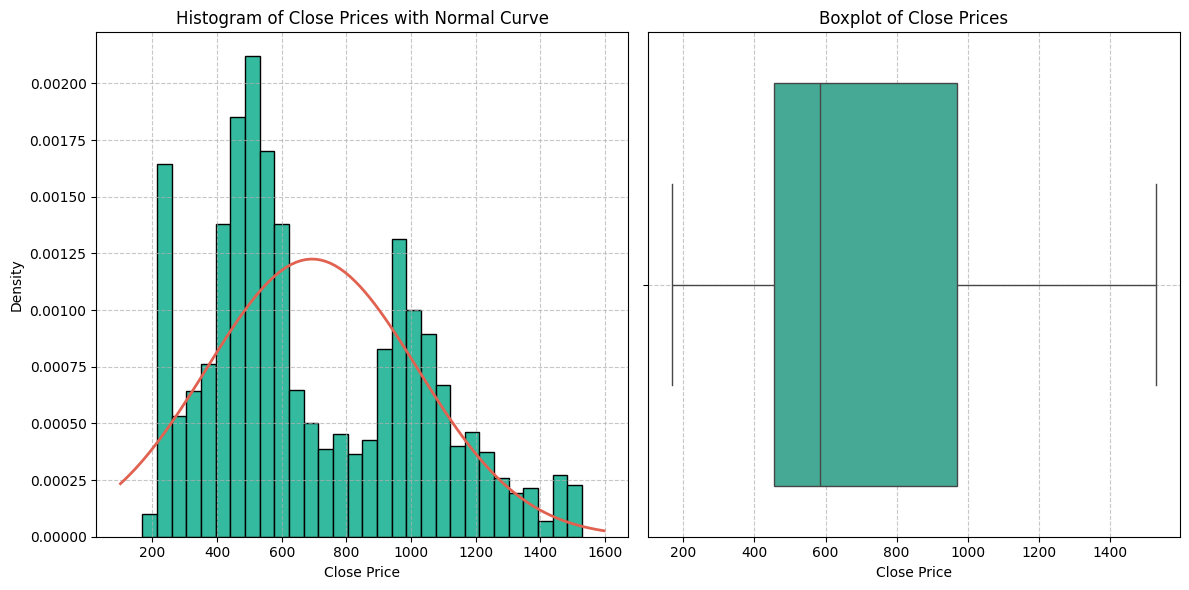

In [133]:
# Draw histogram and boxplot

# Data for plotting
data = df_VNINDEX_raw['Close']

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Histogram with vertical and horizontal grid lines
axs[0].hist(data, bins=30, color='#34BA9F', edgecolor='black', density=True)
axs[0].set_title('Histogram of Close Prices with Normal Curve')
axs[0].set_xlabel('Close Price')
axs[0].set_ylabel('Density')
axs[0].grid(axis='both', linestyle='--', alpha=0.7)

# Add a Normal Distribution Curve
mu, std = norm.fit(data)  # Estimate mean and standard deviation
xmin, xmax = axs[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, '#E16251', linewidth=2)  # Plot normal distribution curve

# Boxplot with vertical grid lines
sns.boxplot(x=data, ax=axs[1], color='#34BA9F')
axs[1].set_title('Boxplot of Close Prices')
axs[1].set_xlabel('Close Price')
axs[1].grid(axis='both', linestyle='--', alpha=0.7)

# Display the plots
plt.tight_layout()
plt.show()


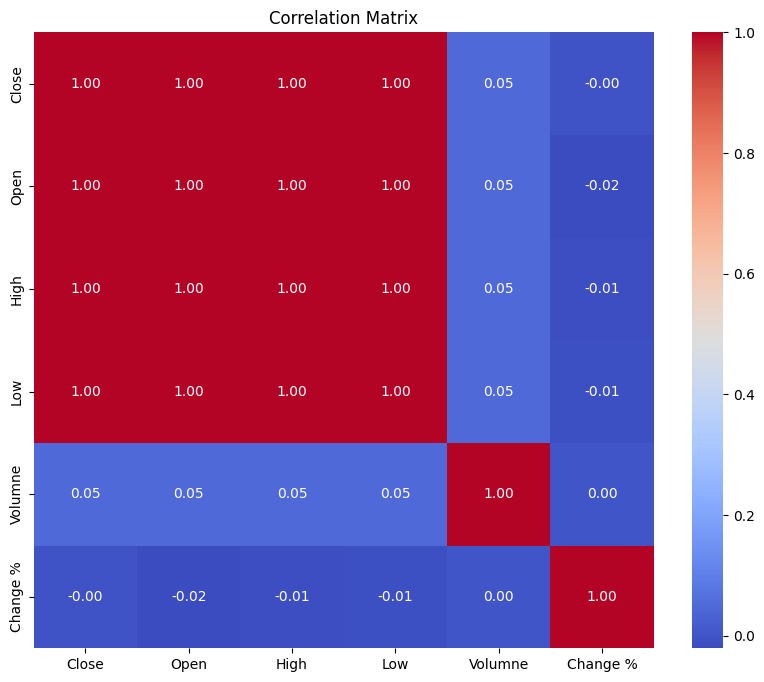

In [134]:
# Check correlation between variable
# Calculate the correlation matrix between the variables.
correlation_matrix = df_VNINDEX_raw.corr()
custom_colors = ['#34bb9d', '#57b57d', '#75ad5f', '#90a345', '#aa9634', '#c18731', '#d4753c', '#e16251']
cmap = sns.color_palette(custom_colors, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm',annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [135]:
# Group data by Year
# Add a 'Year' column to store the year for each date
df_VNINDEX_raw['Year'] = df_VNINDEX_raw['Date'].dt.year

# Sort the DataFrame by 'Year' and 'Date' to get the last day of each year
df_VNINDEX_raw = df_VNINDEX_raw.sort_values(['Year', 'Date'])

# Get the last value of the 'Close' column for each year
df_VNINDEX = df_VNINDEX_raw.groupby('Year').last()['Close'].reset_index()

# Display the result
df_VNINDEX.set_index('Year', inplace=True)
df_VNINDEX.tail(5)


,Close
Year,
2019,960.99
2020,1103.87
2021,1498.28
2022,1007.09
2023,1129.93


# Macroeconomics

In [136]:
# Read the macroeconomics data
df_macroeconomics_raw = pd.read_excel(r"D:\HK5\STAT\Final\dataset\P_Data_Extract_From_World_Development_Indicators (2).xlsx")

# Drop unnecessary columns ('Series Code', 'Country Name', 'Country Code')
df_macroeconomics_raw = df_macroeconomics_raw.drop(['Series Code', 'Country Name','Country Code'], axis=1)

# Clean the column names by removing any parts after '[' (if present)
df_macroeconomics_raw.columns = [df_macroeconomics_raw.columns[0]] + [col.split('[')[0] for col in df_macroeconomics_raw.columns[1:]]

# Drop rows from index 3 onwards (likely to remove header or irrelevant rows)
df_macroeconomics_raw = df_macroeconomics_raw.drop(df_macroeconomics_raw.index[3:])

# Set the 'Series Name' as the index of the DataFrame
df_macroeconomics_raw.set_index('Series Name', inplace=True)

# Reshape the data using melt, which transforms the data to a long format
df_macroeconomics = df_macroeconomics_raw.reset_index().melt(id_vars='Series Name', var_name='Year', value_name='Value')

# Pivot the table so that 'Year' becomes the index, 'Series Name' becomes columns, and 'Value' is the data
df_macroeconomics = df_macroeconomics.pivot_table(index='Year', columns='Series Name', values='Value').reset_index()

# Remove the name of the columns
df_macroeconomics.columns.name = None

# Rename the columns for better readability
df_macroeconomics.columns = ['Year', 'GDP', 'Inflation', 'Unemployment_rate']

# Convert 'Year' to datetime format and extract only the year
df_macroeconomics['Year'] = pd.to_datetime(df_macroeconomics['Year']).dt.year

# Set 'Year' as the index of the DataFrame
df_macroeconomics.set_index('Year', inplace=True)


In [137]:
# Check basic infomation of data
print(df_macroeconomics.info())

# Check null value
print(df_macroeconomics.isnull().sum())

# Descriptive statistics
print(df_macroeconomics.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 2004 to 2024
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP                21 non-null     float64
 1   Inflation          21 non-null     float64
 2   Unemployment_rate  21 non-null     float64
dtypes: float64(3)
memory usage: 672.0 bytes
None
GDP                  0
Inflation            0
Unemployment_rate    0
dtype: int64
             GDP  Inflation  Unemployment_rate
count  21.000000  21.000000          21.000000
mean    6.242772   6.568274           1.674476
std     1.430005   5.450223           0.405616
min     2.553729   0.631201           0.999000
25%     5.553511   3.220934           1.316000
50%     6.500000   4.084554           1.737000
75%     7.129504   8.284572           2.026000
max     8.123514  23.115448           2.385000


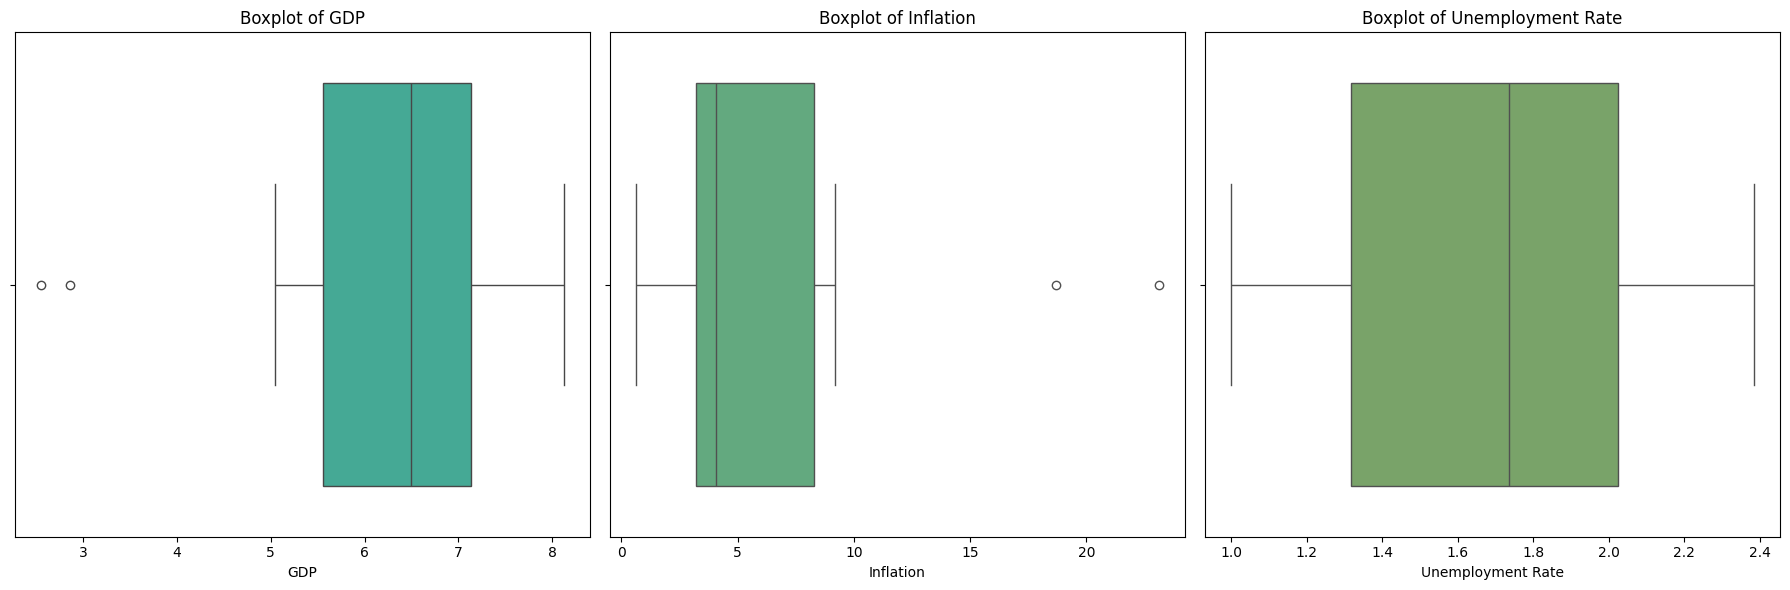

In [138]:
# Create boxplots with horizontal orientation
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Horizontal boxplot for GDP
sns.boxplot(data=df_macroeconomics['GDP'], ax=axs[0], color='#34BA9F', orient='h')
axs[0].set_title('Boxplot of GDP')
axs[0].set_xlabel('GDP')

# Horizontal boxplot for Inflation
sns.boxplot(data=df_macroeconomics['Inflation'], ax=axs[1], color='#57b57d', orient='h')
axs[1].set_title('Boxplot of Inflation')
axs[1].set_xlabel('Inflation')

# Horizontal boxplot for Unemployment Rate
sns.boxplot(data=df_macroeconomics['Unemployment_rate'], ax=axs[2], color='#75ad5f', orient='h')
axs[2].set_title('Boxplot of Unemployment Rate')
axs[2].set_xlabel('Unemployment Rate')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

                        GDP  Inflation  Unemployment_rate
GDP                1.000000   0.037885          -0.223685
Inflation          0.037885   1.000000          -0.202432
Unemployment_rate -0.223685  -0.202432           1.000000


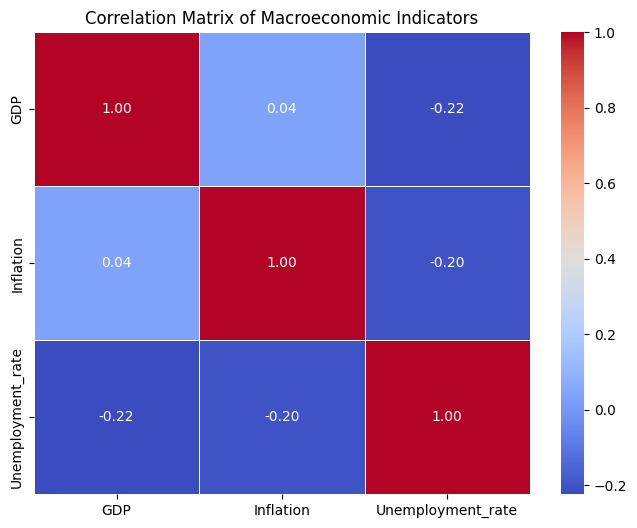

In [139]:
# Calculate the correlation matrix
correlation_matrix = df_macroeconomics[['GDP', 'Inflation', 'Unemployment_rate']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Macroeconomic Indicators')
plt.show()

# 1.2 Analysis

In [140]:
# Descriptive statistics
print(df_macroeconomics.describe()) 

             GDP  Inflation  Unemployment_rate
count  21.000000  21.000000          21.000000
mean    6.242772   6.568274           1.674476
std     1.430005   5.450223           0.405616
min     2.553729   0.631201           0.999000
25%     5.553511   3.220934           1.316000
50%     6.500000   4.084554           1.737000
75%     7.129504   8.284572           2.026000
max     8.123514  23.115448           2.385000


In [141]:
# Insight:
"""
Based on descriptive statistics, Vietnam's average GDP growth rate is 6.2%, the average inflation rate is 6.5%, and the average unemployment
rate is 1.67%. The average inflation rate is higher than the GDP growth rate, which is typical for a developing economy like Vietnam. The high standard 
deviation in inflation indicates significant fluctuations in recent years, likely driven by special events that have impacted the economy

"""

"\nBased on descriptive statistics, Vietnam's average GDP growth rate is 6.2%, the average inflation rate is 6.5%, and the average unemployment\nrate is 1.67%. The average inflation rate is higher than the GDP growth rate, which is typical for a developing economy like Vietnam. The high standard \ndeviation in inflation indicates significant fluctuations in recent years, likely driven by special events that have impacted the economy\n\n"

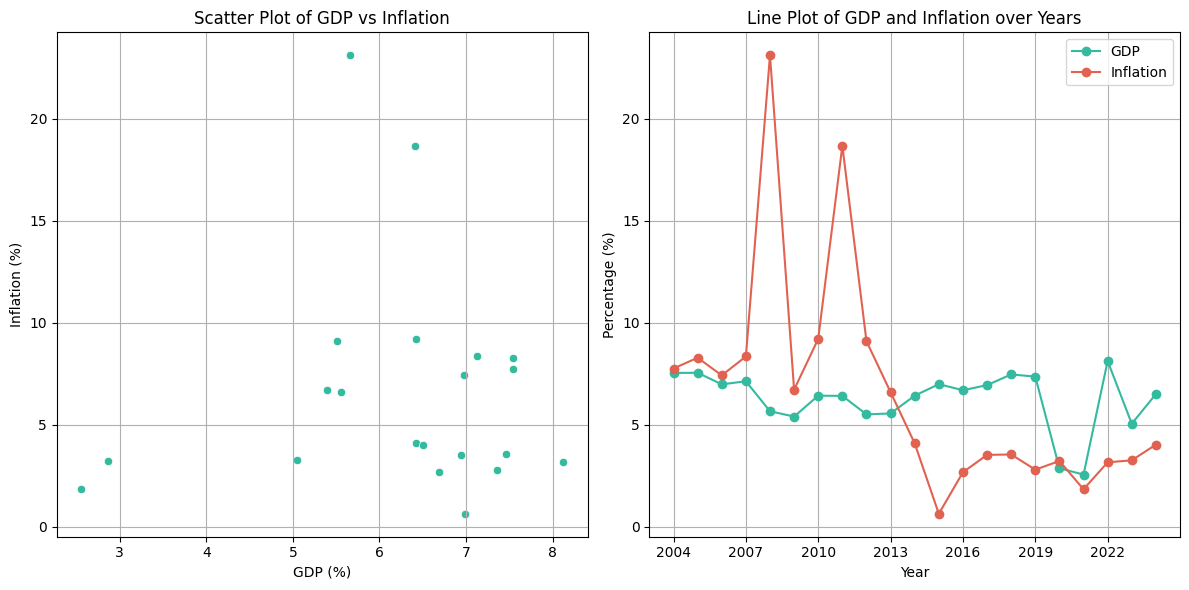

In [142]:
# Chart evaluating GDP and inflation

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Scatter plot to visualize the correlation
sns.scatterplot(data=df_macroeconomics, x='GDP', y='Inflation', ax=axs[0], color='#34BA9F')
axs[0].set_title('Scatter Plot of GDP vs Inflation')
axs[0].set_xlabel('GDP (%)')
axs[0].set_ylabel('Inflation (%)')
axs[0].grid(True)

# Plot 2: Line plot for GDP and Inflation over time
years = list(range(2004, 2025))  # Giả định có 20 năm dữ liệu
axs[1].plot(years, df_macroeconomics['GDP'], label='GDP', marker='o',color='#34BA9F')
axs[1].plot(years, df_macroeconomics['Inflation'], label='Inflation', marker='o',color='#e16251')
axs[1].set_title('Line Plot of GDP and Inflation over Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Percentage (%)')

# Set x-axis ticks every 3 years
axs[1].set_xticks(list(range(2004, 2025, 3)))

axs[1].legend()
axs[1].grid(True)

# Hiển thị tất cả các biểu đồ
plt.tight_layout()
plt.show()


In [143]:
# Insight: 
"""
The analysis of the scatter plot indicates that both inflation and GDP growth rates are distributed around 7%. This observation aligns with the values 
presented in the descriptive statistics table, confirming its accuracy. Additionally, the time-series analysis from 2004 to 2013 reveals that the 
inflation rate consistently exceeded GDP growth during this period. However, in the subsequent years, GDP growth demonstrated higher values compared 
to inflation. The line graph shows some special events, like 2008, 2011, and 2020 => dramatic economic event
"""

'\nThe analysis of the scatter plot indicates that both inflation and GDP growth rates are distributed around 7%. This observation aligns with the values \npresented in the descriptive statistics table, confirming its accuracy. Additionally, the time-series analysis from 2004 to 2013 reveals that the \ninflation rate consistently exceeded GDP growth during this period. However, in the subsequent years, GDP growth demonstrated higher values compared \nto inflation. The line graph shows some special events, like 2008, 2011, and 2020 => dramatic economic event\n'

KMeans clustering result:
           GDP  Inflation  Unemployment_rate  Cluster
Year                                                 
2004  0.926979   0.223106           1.176039        2
2005  0.934745   0.322681           1.016884        2
2006  0.526808   0.159760           0.936043        2
2007  0.635404   0.333938           0.888044        2
2008 -0.416326   3.111030           0.541945        0
2009 -0.605409   0.027959           0.157952        1
2010  0.129321   0.496194          -1.415914        1
2011  0.122101   2.276696          -1.706435        0
2012 -0.528989   0.474993          -1.635700        1
2013 -0.493902   0.004588          -0.905608        1
2014  0.128603  -0.466964          -1.057184        1
2015  0.533400  -1.116228           0.440894        2
2016  0.320475  -0.733243           0.438368        2
2017  0.499747  -0.573057           0.504051        2
2018  0.875814  -0.569415          -1.297180        1
2019  0.800041  -0.709257           0.016481        2
20

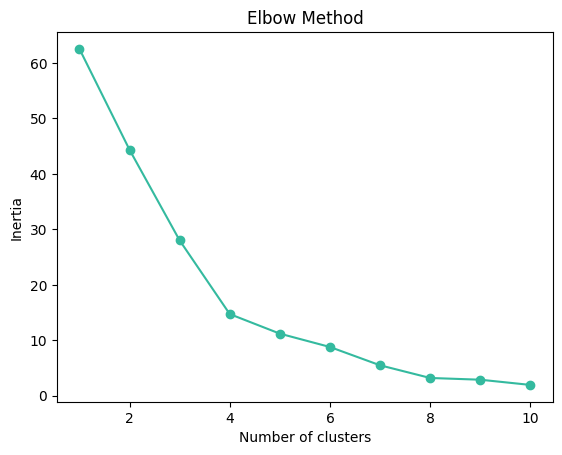

In [144]:
# Using clustering for grouping data
# Standardize using Z-score

scaler = StandardScaler()
df_zscore_scaled = pd.DataFrame(scaler.fit_transform(df_macroeconomics), columns=df_macroeconomics.columns, index=df_macroeconomics.index)
df_zscore_scaled= df_zscore_scaled[df_zscore_scaled.index <2024]
# Apply KMeans clustering algorithm
kmeans = KMeans(n_clusters=4, random_state=42)  # Try with 4 clusters
df_zscore_scaled['Cluster'] = kmeans.fit_predict(df_zscore_scaled)

# Print clustering results
print("KMeans clustering result:")
print(df_zscore_scaled)

# Evaluate the clustering
# Silhouette Score: Measures how similar each sample is to its own cluster compared to other clusters
sil_score = silhouette_score(df_zscore_scaled[df_macroeconomics.columns], kmeans.labels_)
print(f'Silhouette Score: {sil_score}')

# Davies-Bouldin Index: Measures the average similarity ratio of each cluster with the other clusters
db_index = davies_bouldin_score(df_zscore_scaled[df_macroeconomics.columns], kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index}')

# Inertia (SSE): Measures the sum of squared distances from each point to its assigned cluster center
inertia = kmeans.inertia_
print(f'Inertia: {inertia}')

# Plot the Elbow Method to determine the optimal number of clusters
inertia_values = []
for k in range(1, 11):  # Try with 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_zscore_scaled[df_macroeconomics.columns])
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values for different numbers of clusters
plt.plot(range(1, 11), inertia_values, marker='o',color='#34BA9F')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [145]:
# Insight:
"""
Clustering algorithms are unsupervised learning methods used to group data points into clusters based on their similarity. The goal is to ensure 
that points within the same cluster are more similar to each other than to points in other clusters.In this case, we observe that at point 4, there is 
an elbow point. This indicates that using 4 clusters is likely the most appropriate choice, as it balances the trade-off between cluster compactness 
and the number of clusters. Beyond this point, adding more clusters provides diminishing returns, with minimal reduction in inertia, suggesting that 
additional clusters may not significantly improve the model's performance.
From economic theory, it also divide economic cycles in 4 stages => Peak, Recovery, Recession, Trough 
"""

"\nClustering algorithms are unsupervised learning methods used to group data points into clusters based on their similarity. The goal is to ensure \nthat points within the same cluster are more similar to each other than to points in other clusters.In this case, we observe that at point 4, there is \nan elbow point. This indicates that using 4 clusters is likely the most appropriate choice, as it balances the trade-off between cluster compactness \nand the number of clusters. Beyond this point, adding more clusters provides diminishing returns, with minimal reduction in inertia, suggesting that \nadditional clusters may not significantly improve the model's performance.\nFrom economic theory, it also divide economic cycles in 4 stages => Peak, Recovery, Recession, Trough \n"

C:\Users\lyngo\AppData\Local\Temp\ipykernel_26608\2891619045.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='GDP', data=df_macroeconomics, palette=custom_palette, ax=axs[0])
C:\Users\lyngo\AppData\Local\Temp\ipykernel_26608\2891619045.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Inflation', data=df_macroeconomics, palette=custom_palette, ax=axs[1])


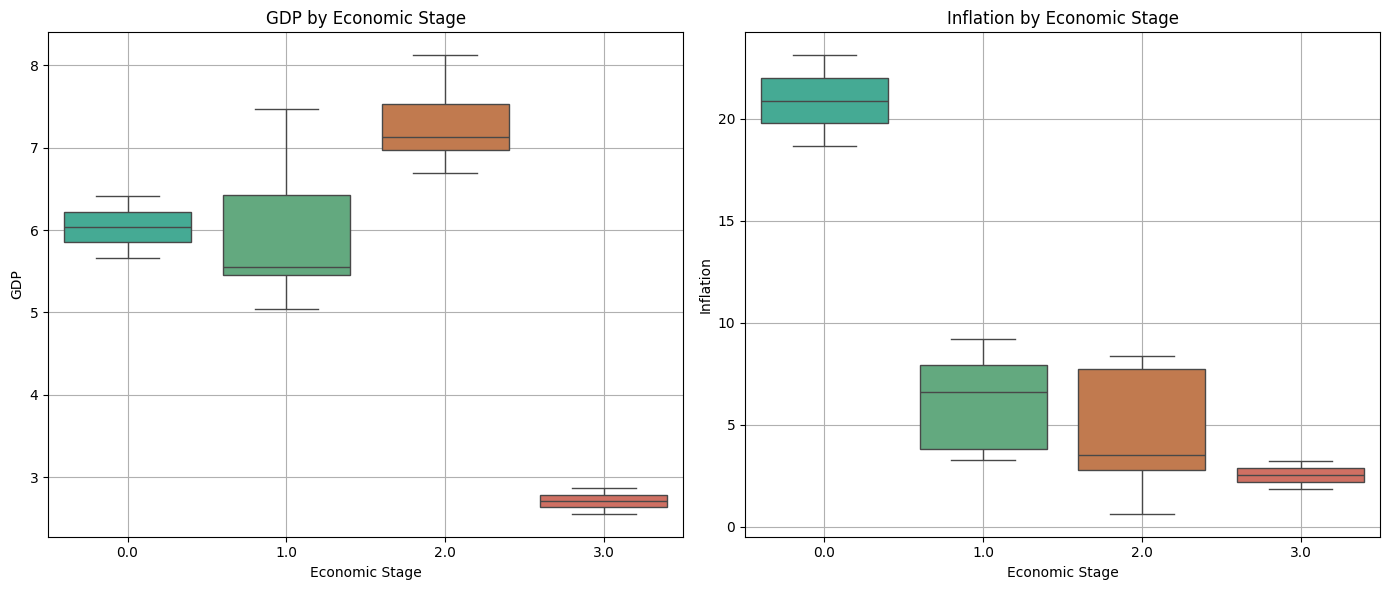

In [146]:
# Group data by economic stages (clusters)
df_macroeconomics['Cluster'] = df_zscore_scaled['Cluster']  
# Group data by clusters and calculate summary statistics
grouped = df_macroeconomics.groupby('Cluster')
summary_stats = grouped.agg(['mean', 'std'])

# Define custom palette with provided colors
custom_palette = ['#34bb9d', '#57b57d', '#d4753c', '#e16251']

# Data Visualization
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1-row, 2-column grid

# Box plot for GDP by economic stage
sns.boxplot(x='Cluster', y='GDP', data=df_macroeconomics, palette=custom_palette, ax=axs[0])
axs[0].set_title('GDP by Economic Stage')
axs[0].set_ylabel('GDP')
axs[0].set_xlabel('Economic Stage')
axs[0].grid(True)

# Box plot for Inflation by economic stage
sns.boxplot(x='Cluster', y='Inflation', data=df_macroeconomics, palette=custom_palette, ax=axs[1])
axs[1].set_title('Inflation by Economic Stage')
axs[1].set_ylabel('Inflation')
axs[1].set_xlabel('Economic Stage')
axs[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [147]:
# Insight:

In [148]:
# Labeling

df_macroeconomics['Stage'] = df_macroeconomics['Cluster'].map({
    0: 'Trough',
    1: 'Recovery',
    2: 'Peak',
    3: 'Recession'
})
df_macroeconomics.drop(['Cluster'], axis=1, inplace=True)
df_macroeconomics = df_macroeconomics[df_macroeconomics.index < 2024]

In [149]:
# Using ANOVA test to determine whether different between Stage
df_macroeconomics=df_macroeconomics.join(df_VNINDEX)

# Grouping by economic stage
group_peak = df_macroeconomics[df_macroeconomics['Stage'] == 'Peak']['Close']
group_recession = df_macroeconomics[df_macroeconomics['Stage'] == 'Recession']['Close']
group_recovery = df_macroeconomics[df_macroeconomics['Stage'] == 'Recovery']['Close']
group_trough =df_macroeconomics[df_macroeconomics['Stage'] == 'Trough']['Close']
# 2.2 Perform ANOVA test
f_stat, p_value = stats.f_oneway(group_peak, group_recession, group_recovery, group_trough)

# Display the results of the test
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Check the results
alpha = 0.05  # Significance level 5%
if p_value < alpha:
    print("Reject the null hypothesis (H0): There is a difference between the stages.")
else:
    print("Fail to reject the null hypothesis (H0): No difference between the stages.")

F-statistic: 4.5883
P-value: 0.0168
Reject the null hypothesis (H0): There is a difference between the stages.


In [150]:
df_macroeconomics

,GDP,Inflation,Unemployment_rate,Stage,Close
Year,,,,,
2004,7.536411,7.754947,2.140,Peak,239.29
2005,7.547248,8.284572,2.077,Peak,307.50
2006,6.977955,7.418017,2.045,Peak,751.77
2007,7.129504,8.344449,2.026,Peak,927.02
2008,5.661771,23.115448,1.889,Trough,315.62
2009,5.397898,6.716983,1.737,Recovery,494.77
2010,6.423245,9.207466,1.114,Recovery,484.66
2011,6.413169,18.677732,0.999,Trough,351.55
2012,5.504545,9.094703,1.027,Recovery,413.73


C:\Users\lyngo\AppData\Local\Temp\ipykernel_26608\2381765050.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Stage', y='GDP', data=df_macroeconomics, order=x_order, palette=custom_palette, ax=axs[0])
C:\Users\lyngo\AppData\Local\Temp\ipykernel_26608\2381765050.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Stage', y='Inflation', data=df_macroeconomics, order=x_order, palette=custom_palette, ax=axs[1])


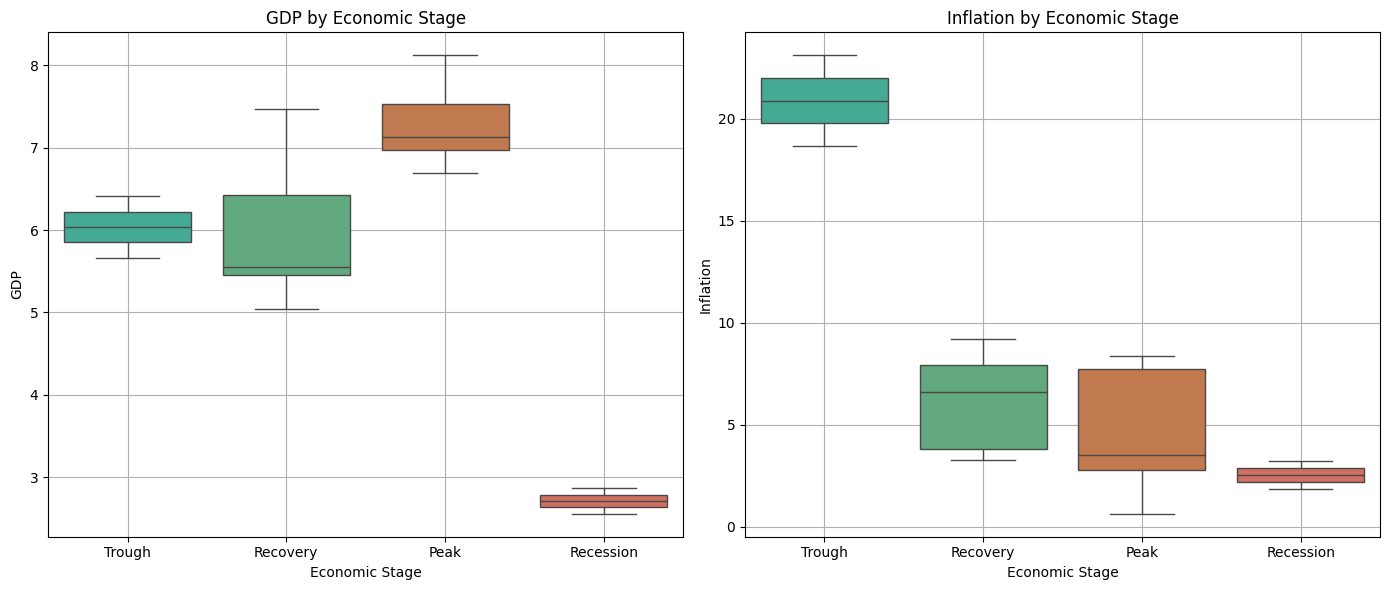

In [151]:
# Grouped summary stats for review
grouped = df_macroeconomics.groupby('Stage')
summary_stats = grouped.agg(['mean', 'std'])

# Define custom palette and order
custom_palette = ['#34bb9d', '#57b57d', '#d4753c', '#e16251']
x_order = ['Trough', 'Recovery', 'Peak', 'Recession']

# Data Visualization
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1-row, 2-column grid

# Box plot for GDP by economic stage
sns.boxplot(x='Stage', y='GDP', data=df_macroeconomics, order=x_order, palette=custom_palette, ax=axs[0])
axs[0].set_title('GDP by Economic Stage')
axs[0].set_ylabel('GDP')
axs[0].set_xlabel('Economic Stage')
axs[0].grid(True)

# Box plot for Inflation by economic stage
sns.boxplot(x='Stage', y='Inflation', data=df_macroeconomics, order=x_order, palette=custom_palette, ax=axs[1])
axs[1].set_title('Inflation by Economic Stage')
axs[1].set_ylabel('Inflation')
axs[1].set_xlabel('Economic Stage')
axs[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

In [152]:
# Insight:
"""
Base on characteritics for each stage, we can label for the data
Group 0: Trough
Group 1: Recovery,
Group 2: Peak,
Group 3: Recession
=> Using Anova test, we can conclude that There is a difference average close between the stages
"""

'\nBase on characteritics for each stage, we can label for the data\nGroup 0: Trough\nGroup 1: Recovery,\nGroup 2: Peak,\nGroup 3: Recession\n=> Using Anova test, we can conclude that There is a difference average close between the stages\n'

In [153]:
# Check correlation between variables 
df_macroeconomics['% Price change'] = (df_macroeconomics['Close'] - df_macroeconomics['Close'].shift(1)) / df_macroeconomics['Close'].shift(1)*100
correlation_matrix = df_macroeconomics[['Close', 'GDP', 'Inflation',]].corr()
print(correlation_matrix)
# Now group by and perform aggregation
grouped = df_macroeconomics.groupby('Stage')
summary_stats = grouped.agg(['mean', 'std'])
summary_stats

              Close       GDP  Inflation
Close      1.000000 -0.408794  -0.597805
GDP       -0.408794  1.000000   0.042577
Inflation -0.597805  0.042577   1.000000


GDP            Inflation           Unemployment_rate  \
               mean       std       mean       std              mean   
Stage                                                                  
Peak       7.254583  0.434792   4.952669  2.965639          1.897222   
Recession  2.709571  0.220394   2.527825  0.980205          2.244000   
Recovery   5.973268  0.838184   6.069843  2.515458          1.316143   
Trough     6.037470  0.531318  20.896590  3.137939          1.444000   

                           Close             % Price change             
                std         mean         std           mean        std  
Stage                                                                   
Peak       0.197778   713.533333  291.109964      30.020188  51.711248  
Recession  0.199404  1301.075000  278.889986      25.298876  14.751485  
Recovery   0.261721   637.984286  266.905267      15.054515  21.356917  
Trough     0.629325   333.585000   25.406347     -46.708942  27.215589

In [154]:
df_macroeconomics['% Price change']

Year
2004           NaN
2005     28.505161
2006    144.478049
2007     23.311651
2008    -65.953270
2009     56.761295
2010     -2.043374
2011    -27.464614
2012     17.687384
2013     21.970851
2014      8.124765
2015      6.121364
2016     14.824793
2017     48.034954
2018     -9.316833
2019      7.669124
2020     14.868001
2021     35.729751
2022    -32.783592
2023     12.197520
Name: % Price change, dtype: float64

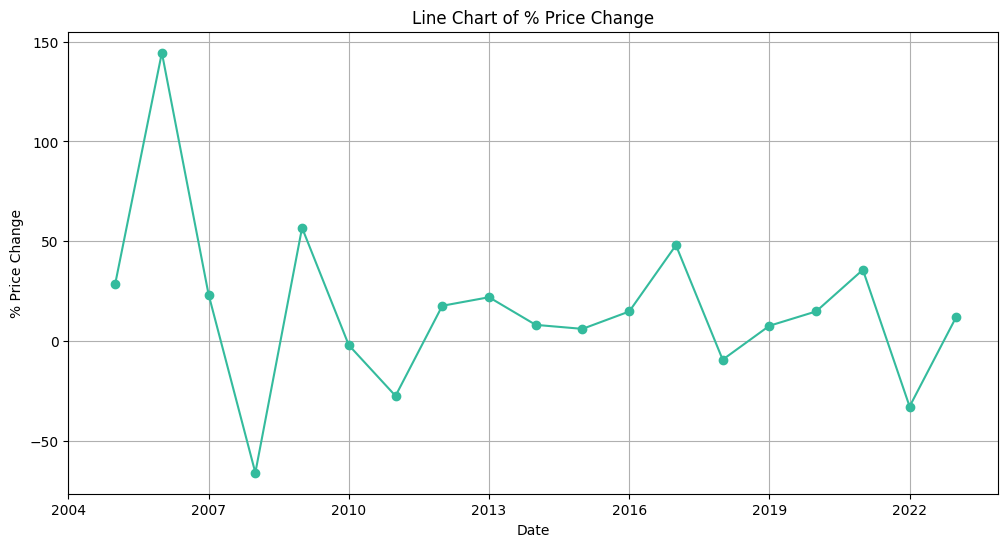

In [155]:
# Plot a line chart for the '% Price change' column with the index as the x-axis
plt.figure(figsize=(12, 6))
plt.plot(df_macroeconomics.index, df_macroeconomics['% Price change'], marker='o', linestyle='-', color='#34bb9d')

# Set chart title and labels
plt.title('Line Chart of % Price Change')
plt.xlabel('Date')
plt.ylabel('% Price Change')

# Set x-ticks at specific intervals (assuming the index is datetime-like or integer)
plt.xticks(list(range(2004, 2025, 3)))

# Display grid lines for better readability
plt.grid(True)

# Show the plot
plt.show()


In [156]:
# Insight
"""
From an initial perspective, it appears that peak periods can yield the highest returns. However, when examining historical data more closely, 
there is a notable "special point" in 2006 where returns exceeded 150%. This extreme value significantly impacts the results and skews them, making 
the analysis less representative of typical trends. In 2006, as Vietnam prepared to join the World Trade Organization (WTO), investor optimism surged. 
Many believed that Vietnam's entry into this organization would lead to substantial growth in the stock market, contributing to this exceptional spike 
in returns.
"""

'\nFrom an initial perspective, it appears that peak periods can yield the highest returns. However, when examining historical data more closely, \nthere is a notable "special point" in 2006 where returns exceeded 150%. This extreme value significantly impacts the results and skews them, making \nthe analysis less representative of typical trends. In 2006, as Vietnam prepared to join the World Trade Organization (WTO), investor optimism surged. \nMany believed that Vietnam\'s entry into this organization would lead to substantial growth in the stock market, contributing to this exceptional spike \nin returns.\n'

In [157]:
# Removing abnormal value
filtered_df = df_macroeconomics[df_macroeconomics.index != 2006]
# Now group by and perform aggregation
grouped = filtered_df.groupby('Stage')
summary_stats = grouped.agg(['mean', 'std'])
summary_stats

GDP            Inflation           Unemployment_rate  \
               mean       std       mean       std              mean   
Stage                                                                  
Peak       7.289162  0.451389   4.644501  3.012413          1.878750   
Recession  2.709571  0.220394   2.527825  0.980205          2.244000   
Recovery   5.973268  0.838184   6.069843  2.515458          1.316143   
Trough     6.037470  0.531318  20.896590  3.137939          1.444000   

                           Close             % Price change             
                std         mean         std           mean        std  
Stage                                                                   
Peak       0.202964   708.753750  310.831901      13.669065  24.987516  
Recession  0.199404  1301.075000  278.889986      25.298876  14.751485  
Recovery   0.261721   637.984286  266.905267      15.054515  21.356917  
Trough     0.629325   333.585000   25.406347     -46.708942  27.215589

In [158]:
# Insight
"""
When eliminating such "special points," deeper insights can emerge. During recession phases, returns reached their highest levels. This can be explained 
by government measures to mitigate economic downturns, including reducing interest rates to historically low levels, often no more than 1.5%. These 
lower rates enabled investors to borrow at minimal costs for investment purposes. Additionally, following significant downturns, such as the COVID-19 
pandemic in 2019, many investors anticipated a recovery and growth in Vietnam’s economy, fueling increased investment activity.
"""

'\nWhen eliminating such "special points," deeper insights can emerge. During recession phases, returns reached their highest levels. This can be explained \nby government measures to mitigate economic downturns, including reducing interest rates to historically low levels, often no more than 1.5%. These \nlower rates enabled investors to borrow at minimal costs for investment purposes. Additionally, following significant downturns, such as the COVID-19 \npandemic in 2019, many investors anticipated a recovery and growth in Vietnam’s economy, fueling increased investment activity.\n'

In [159]:
# Comparing VNINDEX and DOWJONE (data)

# VNINDEX data
df_VNINDEX_raw1= pd.read_csv(r"D:\HK5\STAT\Final\dataset\VNINDEX-20222024.csv")
# Rename columns
df_VNINDEX_raw1=df_VNINDEX_raw1.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_VNINDEX_raw1['Date'] = pd.to_datetime(df_VNINDEX_raw1['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_VNINDEX_raw1['Close'] = pd.to_numeric(df_VNINDEX_raw1['Close'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw1['Open'] = pd.to_numeric(df_VNINDEX_raw1['Open'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw1['High'] = pd.to_numeric(df_VNINDEX_raw1['High'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw1['Low'] = pd.to_numeric(df_VNINDEX_raw1['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_VNINDEX_raw1['Change %'] = pd.to_numeric(
    df_VNINDEX_raw1['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric

# Apply the conversion function to 'Volumne' column
df_VNINDEX_raw1['Volumne'] = df_VNINDEX_raw1['Volumne'].apply(convert_to_number)

# Display DataFrame info to verify changes
df_VNINDEX_raw1.info()
df_VNINDEX_raw1.tail(5)
# VNINDEX data
df_DowJone_raw1= pd.read_csv(r"D:\HK5\STAT\Final\dataset\DowJone20222024.csv")
# Rename columns
df_DowJone_raw1=df_DowJone_raw1.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_DowJone_raw1['Date'] = pd.to_datetime(df_DowJone_raw1['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_DowJone_raw1['Close'] = pd.to_numeric(df_DowJone_raw1['Close'].str.replace(',', '', regex=True), errors='coerce')
df_DowJone_raw1['Open'] = pd.to_numeric(df_DowJone_raw1['Open'].str.replace(',', '', regex=True), errors='coerce')
df_DowJone_raw1['High'] = pd.to_numeric(df_DowJone_raw1['High'].str.replace(',', '', regex=True), errors='coerce')
df_DowJone_raw1['Low'] = pd.to_numeric(df_DowJone_raw1['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_DowJone_raw1['Change %'] = pd.to_numeric(
    df_DowJone_raw1['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric

# Apply the conversion function to 'Volumne' column
df_DowJone_raw1['Volumne'] = df_DowJone_raw1['Volumne'].apply(convert_to_number)

# Display DataFrame info to verify changes
df_DowJone_raw1.info()
df_DowJone_raw1.tail(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      707 non-null    datetime64[ns]
 1   Close     707 non-null    float64       
 2   Open      707 non-null    float64       
 3   High      707 non-null    float64       
 4   Low       707 non-null    float64       
 5   Volumne   706 non-null    float64       
 6   Change %  707 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 38.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      713 non-null    datetime64[ns]
 1   Close     713 non-null    float64       
 2   Open      713 non-null    float64       
 3   High      713 non-null    float64       
 4   Low       713 non-null    float64    

,Date,Close,Open,High,Low,Volumne,Change %
698,2022-01-31,35131.86,34691.17,35148.14,34496.10,474440000.0,1.17
699,2022-01-28,34725.47,34135.24,34731.77,33807.51,568440000.0,1.65
700,2022-01-27,34160.78,34261.75,34773.32,34007.78,527780000.0,-0.02
701,2022-01-26,34168.09,34520.82,34815.67,33876.48,549310000.0,-0.38
702,2022-01-25,34297.73,34186.64,34591.04,33545.52,522190000.0,-0.19
703,2022-01-24,34364.50,34070.61,34420.99,33150.33,678120000.0,0.29
704,2022-01-21,34265.37,34701.69,34896.67,34229.55,523880000.0,-1.30
705,2022-01-20,34715.39,35102.66,35490.20,34670.12,369070000.0,-0.89
706,2022-01-19,35028.65,35412.30,35547.83,35015.49,393080000.0,-0.96
707,2022-01-18,35368.47,35661.76,35661.76,35262.02,427260000.0,-1.51


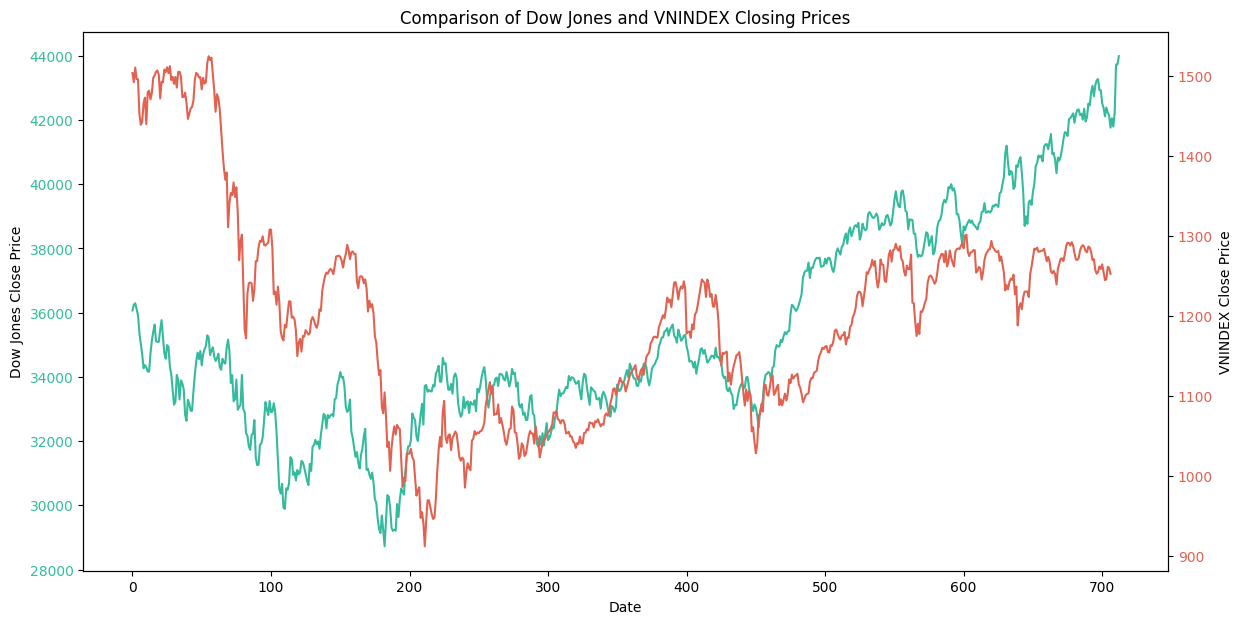

In [160]:
# Comparing VNINDEX and DOWJONE (chart)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Dow Jones data with reversed order
ax1.plot(df_DowJone_raw1.index[::-1], df_DowJone_raw1['Close'], label='Dow Jones Close Price', color='#34bb9d')
ax1.set_xlabel('Date')
ax1.set_ylabel('Dow Jones Close Price', color='black')
ax1.tick_params(axis='y', labelcolor='#34bb9d')

# Plot the VNINDEX data with reversed order on the second y-axis
ax2 = ax1.twinx()
ax2.plot(df_VNINDEX_raw1.index[::-1], df_VNINDEX_raw1['Close'], label='VNINDEX Close Price', color='#e16251')
ax2.set_ylabel('VNINDEX Close Price', color='black')
ax2.tick_params(axis='y', labelcolor='#e16251')

# Add title
plt.title('Comparison of Dow Jones and VNINDEX Closing Prices')

# Show plot
plt.show()

In [161]:
# Insight: 

# 2. Applying machine learning models to analyze bank stock prices

## 2.2 Randomforest combine Simple Regression

### 2.2.1 Exploratory Data Analyst

#### Preparing data

In [162]:
# VCB data
df_VCB_raw= pd.read_csv(r"D:\HK5\STAT\Final\dataset\VCB.csv")
# Rename columns
df_VCB_raw=df_VCB_raw.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_VCB_raw['Date'] = pd.to_datetime(df_VCB_raw['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_VCB_raw['Close'] = pd.to_numeric(df_VCB_raw['Close'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['Open'] = pd.to_numeric(df_VCB_raw['Open'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['High'] = pd.to_numeric(df_VCB_raw['High'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['Low'] = pd.to_numeric(df_VCB_raw['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_VCB_raw['Change %'] = pd.to_numeric(
    df_VCB_raw['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric

# Apply the conversion function to 'Volumne' column
df_VCB_raw['Volumne'] = df_VCB_raw['Volumne'].apply(convert_to_number)

# Display DataFrame info to verify changes
df_VCB_raw.info()
df_VCB_raw = df_VCB_raw.ffill()
df_VCB_raw.set_index('Date', inplace=True)
df_VCB_raw = df_VCB_raw.sort_index(ascending=True)
df_VCB_raw 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1207 non-null   datetime64[ns]
 1   Close     1207 non-null   int64         
 2   Open      1207 non-null   int64         
 3   High      1207 non-null   int64         
 4   Low       1207 non-null   int64         
 5   Volumne   1206 non-null   float64       
 6   Change %  1207 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 66.1 KB


,Close,Open,High,Low,Volumne,Change %
Date,,,,,,
2020-01-02,69728,69267,70189,68883,492910.0,0.67
2020-01-03,69037,70265,70496,69037,684100.0,-0.99
2020-01-06,67194,68499,68730,67194,1120000.0,-2.67
2020-01-07,67424,66810,67501,65581,1290000.0,0.34
2020-01-08,66810,66733,67501,66195,921630.0,-0.91
...,...,...,...,...,...,...
2024-10-25,91800,92100,92300,91700,1050000.0,0.11
2024-10-28,92000,91500,92300,91500,1130000.0,0.22
2024-10-29,92000,92100,92600,92000,1400000.0,0.00


In [163]:
# Read the macroeconomics data
df_macroeconomics_raw = pd.read_excel(r"D:\HK5\STAT\Final\dataset\P_Data_Extract_From_World_Development_Indicators (2).xlsx")

# Drop unnecessary columns ('Series Code', 'Country Name', 'Country Code')
df_macroeconomics_raw = df_macroeconomics_raw.drop(['Series Code', 'Country Name','Country Code'], axis=1)

# Clean the column names by removing any parts after '[' (if present)
df_macroeconomics_raw.columns = [df_macroeconomics_raw.columns[0]] + [col.split('[')[0] for col in df_macroeconomics_raw.columns[1:]]

# Drop rows from index 3 onwards (likely to remove header or irrelevant rows)
df_macroeconomics_raw = df_macroeconomics_raw.drop(df_macroeconomics_raw.index[3:])

# Set the 'Series Name' as the index of the DataFrame
df_macroeconomics_raw.set_index('Series Name', inplace=True)

# Reshape the data using melt, which transforms the data to a long format
df_macroeconomics = df_macroeconomics_raw.reset_index().melt(id_vars='Series Name', var_name='Year', value_name='Value')

# Pivot the table so that 'Year' becomes the index, 'Series Name' becomes columns, and 'Value' is the data
df_macroeconomics = df_macroeconomics.pivot_table(index='Year', columns='Series Name', values='Value').reset_index()

# Remove the name of the columns
df_macroeconomics.columns.name = None

# Rename the columns for better readability
df_macroeconomics.columns = ['Year', 'GDP', 'Inflation', 'Unemployment_rate']

# Convert 'Year' to datetime format and extract only the year
df_macroeconomics['Year'] = pd.to_datetime(df_macroeconomics['Year']).dt.year

# Set 'Year' as the index of the DataFrame
df_macroeconomics.set_index('Year', inplace=True)
df_macroeconomics

,GDP,Inflation,Unemployment_rate
Year,,,
2004,7.536411,7.754947,2.140
2005,7.547248,8.284572,2.077
2006,6.977955,7.418017,2.045
2007,7.129504,8.344449,2.026
2008,5.661771,23.115448,1.889
2009,5.397898,6.716983,1.737
2010,6.423245,9.207466,1.114
2011,6.413169,18.677732,0.999
2012,5.504545,9.094703,1.027


In [164]:
# Combing data 
df_macroeconomics_main = df_macroeconomics[['GDP','Inflation','Unemployment_rate']]
df_macroeconomics_main
data_arimax = df_VCB_raw.copy()
data_arimax['Year'] = data_arimax.index.year
data_arimax =data_arimax.merge(df_macroeconomics_main, left_on='Year', right_index=True, how='left')
data_arimax = data_arimax[['Close','GDP','Inflation','Unemployment_rate']]
data_arimax = data_arimax.sort_index(ascending=True)
df_interest = pd.read_excel(r"D:\HK5\STAT\Final\dataset\Rate.xlsx")
df_interest['Date'] = pd.to_datetime(df_interest['Year'].astype(str) + df_interest['Month'].astype(str).str.zfill(2), format='%Y%m')
df_interest.set_index('Date', inplace=True)
df_interest.drop(columns=['Year', 'Month'], inplace=True)
df_interest.tail(20)
data_arimax['Rate'] = data_arimax.index.to_period('M').map(
    lambda date: df_interest['Rate'].get(date.to_timestamp(), None)
)

#### Check basic infomation

In [165]:
# Check basic infomation of data
print(data_arimax.info())

# Check null value
print(data_arimax.isnull().sum())

# Descriptive statistics
print(data_arimax.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1207 entries, 2020-01-02 to 2024-10-31
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Close              1207 non-null   int64  
 1   GDP                1207 non-null   float64
 2   Inflation          1207 non-null   float64
 3   Unemployment_rate  1207 non-null   float64
 4   Rate               1207 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 56.6 KB
None
Close                0
GDP                  0
Inflation            0
Unemployment_rate    0
Rate                 0
dtype: int64
              Close          GDP    Inflation  Unemployment_rate         Rate
count   1207.000000  1207.000000  1207.000000        1207.000000  1207.000000
mean   76395.287490     4.958851     3.064498           1.837464     4.000961
std    11025.415788     2.142878     0.696463           0.356038     2.253829
min    43925.000000     2.553729     1.83471

#### Check correlation between variable

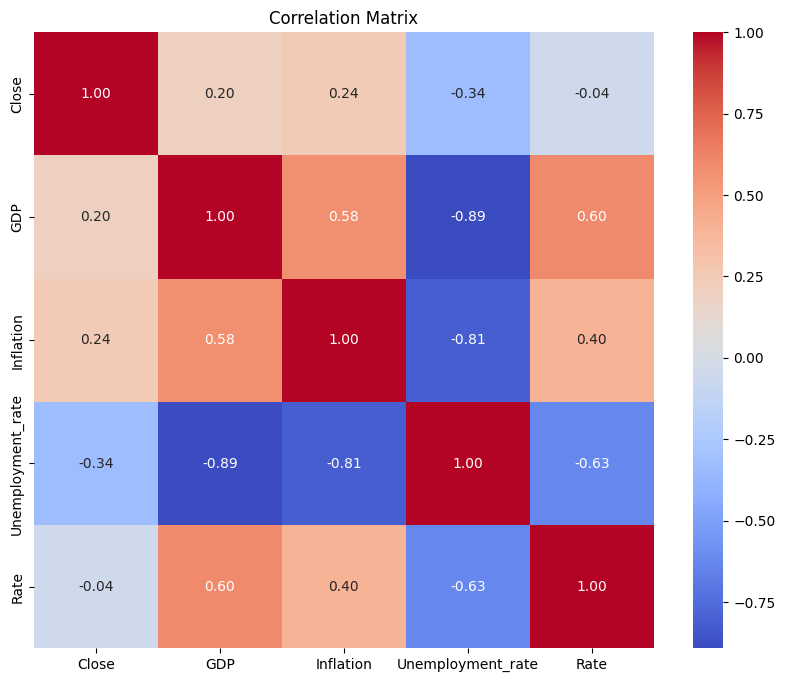

In [166]:
# Check correlation between variable
correlation_matrix = data_arimax.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### 2.2.2 Apply Simple Regression

#### Check lag correlation

C:\Users\lyngo\AppData\Local\Temp\ipykernel_26608\3721481691.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette=custom_palette)


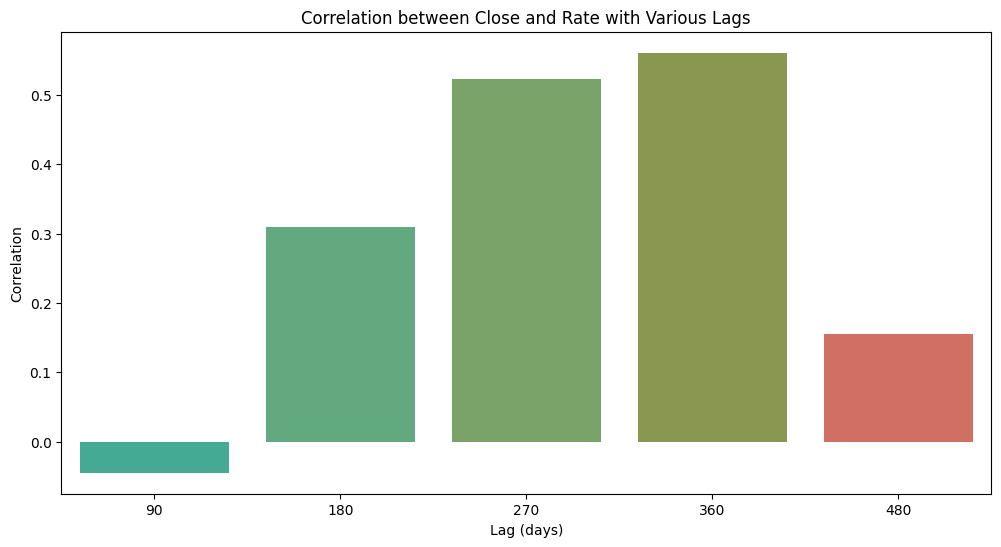

In [167]:
# Lag for Rate
data_test = data_arimax.copy()
# Create a list of lags (multiples of 30)
lags = [90, 180, 270, 360, 480]
correlations = []

# Calculate the correlation between 'Close' and 'Rate' for each lag
for lag in lags:
    data_test[f'Close_lag_{lag}'] = data_test['Close'].shift(lag)
    correlation = data_test[['Rate', f'Close_lag_{lag}']].corr().iloc[0, 1]
    correlations.append((lag, correlation))

# Convert the list of correlations into a DataFrame for easy plotting
correlation_df = pd.DataFrame(correlations, columns=['Lag', 'Correlation'])
custom_palette = ['#34bb9d', '#57b57d', '#75ad5f', '#90a345', '#e16251']

# Plot the correlation with various lags
plt.figure(figsize=(12, 6))
sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette=custom_palette)
plt.title('Correlation between Close and Rate with Various Lags')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()

C:\Users\lyngo\AppData\Local\Temp\ipykernel_26608\3348818853.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette=custom_palette)


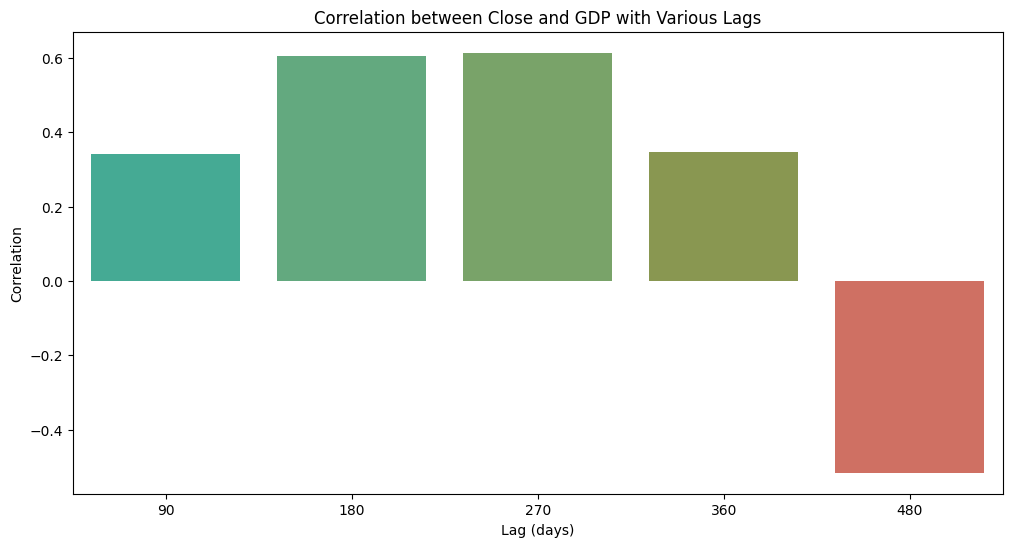

In [168]:
# Create a list of lags (multiples of 30)
lags = [90, 180, 270, 360, 480]
correlations = []

# Calculate the correlation between 'Close' and 'Rate' for each lag
for lag in lags:
    correlation = data_test[['GDP', f'Close_lag_{lag}']].corr().iloc[0, 1]
    correlations.append((lag, correlation))

# Convert the list of correlations into a DataFrame for easy plotting
correlation_df = pd.DataFrame(correlations, columns=['Lag', 'Correlation'])

# Plot the correlation with various lags
plt.figure(figsize=(12, 6))
sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette=custom_palette)
plt.title('Correlation between Close and GDP with Various Lags')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()

C:\Users\lyngo\AppData\Local\Temp\ipykernel_26608\2710526165.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette=custom_palette)


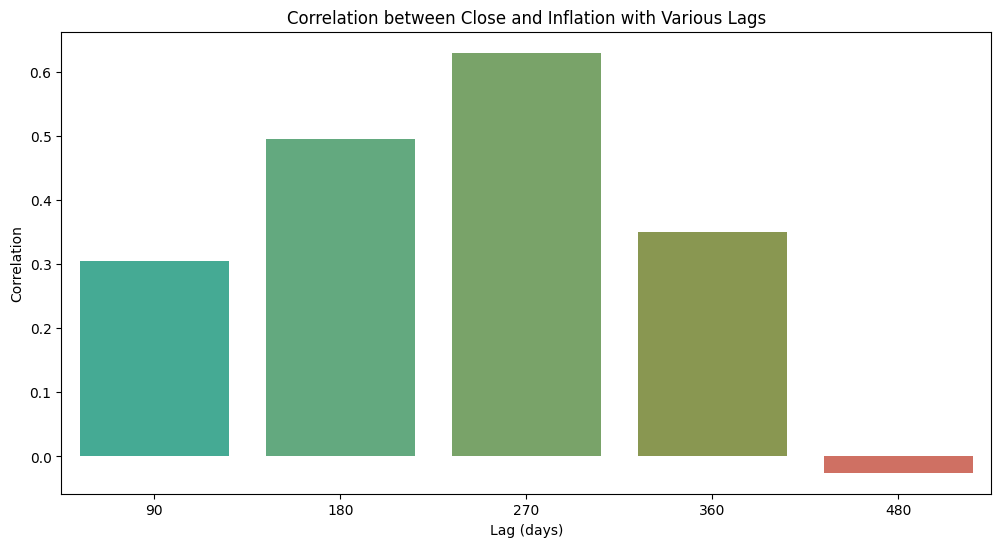

In [169]:
# Create a list of lags (multiples of 30)
lags = [90, 180, 270, 360, 480]
correlations = []

# Calculate the correlation between 'Close' and 'Rate' for each lag
for lag in lags:
    correlation = data_test[['Inflation', f'Close_lag_{lag}']].corr().iloc[0, 1]
    correlations.append((lag, correlation))

# Convert the list of correlations into a DataFrame for easy plotting
correlation_df = pd.DataFrame(correlations, columns=['Lag', 'Correlation'])

# Plot the correlation with various lags
plt.figure(figsize=(12, 6))
sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette=custom_palette)
plt.title('Correlation between Close and Inflation with Various Lags')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()

C:\Users\lyngo\AppData\Local\Temp\ipykernel_26608\1890387751.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette=custom_palette)


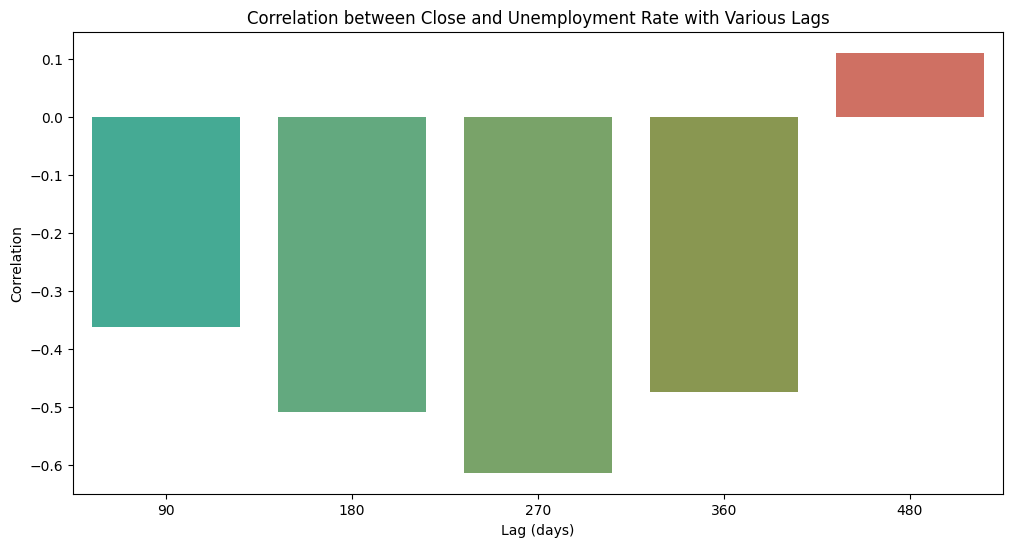

,Close,GDP,Inflation,Unemployment_rate,Rate,Close_lag_90,Close_lag_180,Close_lag_270,Close_lag_360,Close_lag_480
Date,,,,,,,,,,
2020-01-02,69728,2.865413,3.220934,2.103,5.18,NaN,NaN,NaN,NaN,NaN
2020-01-03,69037,2.865413,3.220934,2.103,5.18,NaN,NaN,NaN,NaN,NaN
2020-01-06,67194,2.865413,3.220934,2.103,5.18,NaN,NaN,NaN,NaN,NaN
2020-01-07,67424,2.865413,3.220934,2.103,5.18,NaN,NaN,NaN,NaN,NaN
2020-01-08,66810,2.865413,3.220934,2.103,5.18,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-10-25,91800,6.500000,4.022000,1.500,4.46,86600.0,89800.0,87800.0,78831.0,62235.0
2024-10-28,92000,6.500000,4.022000,1.500,4.46,86000.0,90300.0,88000.0,78577.0,62235.0
2024-10-29,92000,6.500000,4.022000,1.500,4.46,86000.0,90000.0,87500.0,78408.0,61812.0


In [170]:
# Create a list of lags (multiples of 30)
lags = [90, 180, 270, 360, 480]
correlations = []

# Calculate the correlation between 'Close' and 'Rate' for each lag
for lag in lags:
    correlation = data_test[['Unemployment_rate', f'Close_lag_{lag}']].corr().iloc[0, 1]
    correlations.append((lag, correlation))

# Convert the list of correlations into a DataFrame for easy plotting
correlation_df = pd.DataFrame(correlations, columns=['Lag', 'Correlation'])

# Plot the correlation with various lags
plt.figure(figsize=(12, 6))
sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette=custom_palette)
plt.title('Correlation between Close and Unemployment Rate with Various Lags')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()
data_test

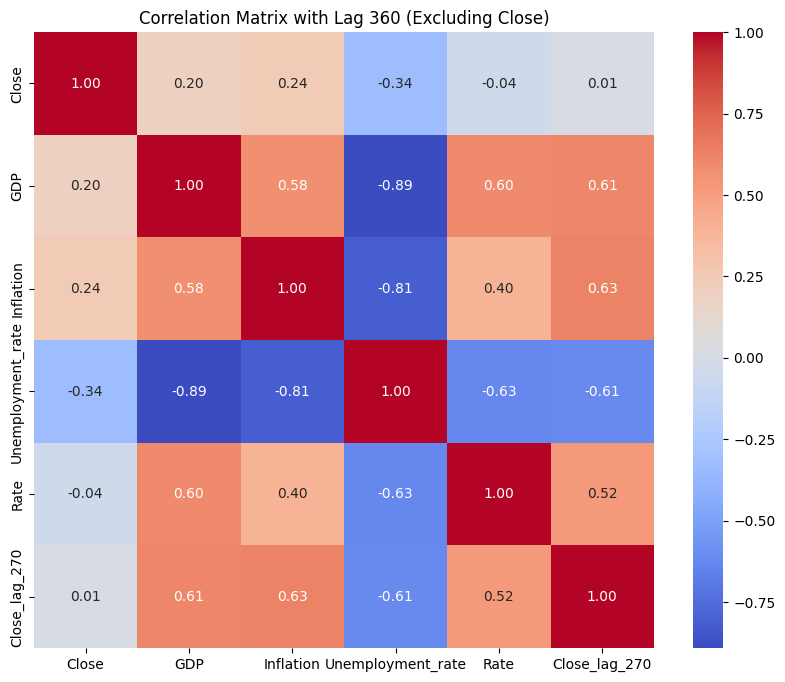

In [171]:
# Correlation with lag
# Assuming data_arimax is your DataFrame
# Create lag 360 for all columns except 'Close'
lag = 270
data_rf_lagged = data_arimax.copy()  # Copy the 'Close' column
"""
# Create lag 360 for all columns except 'Close'
for column in data_arimax.columns:
    if column != 'Close':
        data_rf_lagged[column + '_lag_360'] = data_arimax[column].shift(lag)
"""
data_rf_lagged['Close_lag_270']= data_rf_lagged['Close'].shift(270)
correlation_matrix = data_rf_lagged.corr()
# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with Lag 360 (Excluding Close)')
plt.show()



In [172]:
# Check for null (NaN) values in each column of data_arimax_lagged
null_values_per_column = data_rf_lagged.isnull().sum()

# Display the count of null values for each column
print(null_values_per_column)

Close                  0
GDP                    0
Inflation              0
Unemployment_rate      0
Rate                   0
Close_lag_270        270
dtype: int64


#### Replace null by using regression model

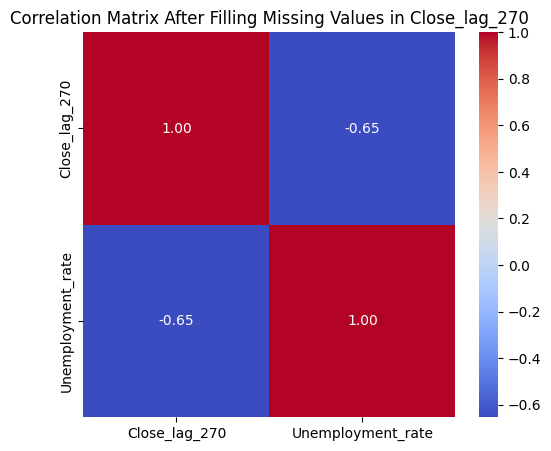

Correlation between Close and GDP_lag_360: -0.6536424752821236


In [173]:
# Replace GDP null
# Step 1: Drop rows with NaN in 'GDP_lag_360' and 'Close'
train_data =  data_rf_lagged.dropna(subset=['Unemployment_rate', 'Close_lag_270'])

# Step 2: Prepare training data (X_train with 'Close', y_train with 'GDP_lag_360')
X_train = train_data[['Unemployment_rate']]  # Feature: Close
y_train = train_data['Close_lag_270']  # Target: GDP_lag_360

# Step 3: Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict missing values in 'GDP_lag_360'
missing_data =  data_rf_lagged[data_rf_lagged['Close_lag_270'].isna()]
X_missing = missing_data[['Unemployment_rate']]  # Feature for missing values: Close
predictions = model.predict(X_missing)

# Step 5: Fill missing 'GDP_lag_360' values with predicted values
data_rf_lagged.loc[data_rf_lagged['Close_lag_270'].isna(), 'Close_lag_270'] = predictions

# Step 6: Compute correlation matrix
correlation_matrix =  data_rf_lagged[['Close_lag_270', 'Unemployment_rate']].corr()

# Step 7: Plot heatmap of the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix After Filling Missing Values in Close_lag_270')
plt.show()

# Step 8: Print the correlation between 'Close' and 'GDP_lag_360' to check if it has been maintained
print(f"Correlation between Close and GDP_lag_360: {correlation_matrix.loc['Close_lag_270', 'Unemployment_rate']}")


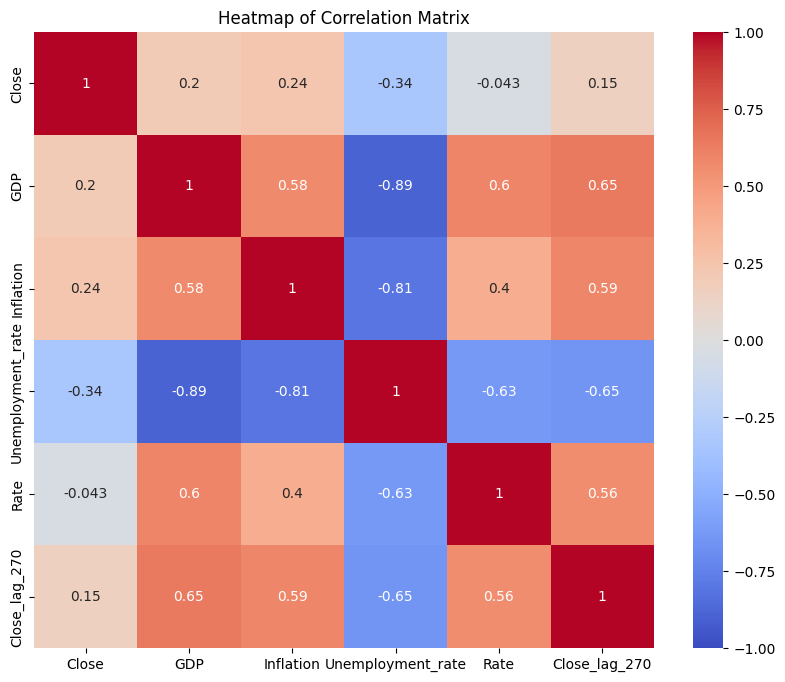

In [174]:
# Tính toán ma trận hệ số tương quan
correlation_matrix = data_rf_lagged.corr()

# Vẽ heatmap bằng seaborn
plt.figure(figsize=(10, 8))  # Kích thước tùy chỉnh cho đồ thị
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Hiển thị đồ thị
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [175]:
 data_rf_lagged

,Close,GDP,Inflation,Unemployment_rate,Rate,Close_lag_270
Date,,,,,,
2020-01-02,69728,2.865413,3.220934,2.103,5.18,67073.370695
2020-01-03,69037,2.865413,3.220934,2.103,5.18,67073.370695
2020-01-06,67194,2.865413,3.220934,2.103,5.18,67073.370695
2020-01-07,67424,2.865413,3.220934,2.103,5.18,67073.370695
2020-01-08,66810,2.865413,3.220934,2.103,5.18,67073.370695
...,...,...,...,...,...,...
2024-10-25,91800,6.500000,4.022000,1.500,4.46,87800.000000
2024-10-28,92000,6.500000,4.022000,1.500,4.46,88000.000000
2024-10-29,92000,6.500000,4.022000,1.500,4.46,87500.000000


### 2.2.3 Construct technical indicators

#### Compute technical index

In [176]:
# Compute SMA and EMA 
data_rf_lagged['SMA_100'] =  data_rf_lagged['Close'].rolling(window=100).mean()
data_rf_lagged['SMA_200'] =  data_rf_lagged['Close'].rolling(window=200).mean()
data_rf_lagged['SMA_50'] =  data_rf_lagged['Close'].rolling(window=50).mean()
data_rf_lagged['EMA_50'] =  data_rf_lagged['Close'].ewm(span=50, adjust=False).mean()
data_rf_lagged['RSI_14'] = ta.momentum.RSIIndicator( data_rf_lagged['Close'], window=14).rsi()
# Fill NAN value by mean
data_rf_lagged['SMA_100'] =  data_rf_lagged['SMA_100'].fillna( data_rf_lagged['SMA_100'].mean())
data_rf_lagged['SMA_200'] =  data_rf_lagged['SMA_200'].fillna( data_rf_lagged['SMA_200'].mean())
data_rf_lagged['SMA_50'] = data_rf_lagged['SMA_50'].fillna( data_rf_lagged['SMA_50'].mean())
data_rf_lagged['RSI_14'] =  data_rf_lagged['RSI_14'].fillna( data_rf_lagged['RSI_14'].mean())
data_rf_lagged

,Close,GDP,Inflation,Unemployment_rate,Rate,Close_lag_270,SMA_100,SMA_200,SMA_50,EMA_50,RSI_14
Date,,,,,,,,,,,
2020-01-02,69728,2.865413,3.220934,2.103,5.18,67073.370695,76358.493944,76441.384707,76244.981848,69728.000000,51.265362
2020-01-03,69037,2.865413,3.220934,2.103,5.18,67073.370695,76358.493944,76441.384707,76244.981848,69700.901961,51.265362
2020-01-06,67194,2.865413,3.220934,2.103,5.18,67073.370695,76358.493944,76441.384707,76244.981848,69602.592080,51.265362
2020-01-07,67424,2.865413,3.220934,2.103,5.18,67073.370695,76358.493944,76441.384707,76244.981848,69517.157096,51.265362
2020-01-08,66810,2.865413,3.220934,2.103,5.18,67073.370695,76358.493944,76441.384707,76244.981848,69410.994073,51.265362
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25,91800,6.500000,4.022000,1.500,4.46,87800.000000,89338.600000,90670.800000,91141.000000,91009.582352,52.756894
2024-10-28,92000,6.500000,4.022000,1.500,4.46,88000.000000,89368.600000,90699.800000,91229.000000,91048.422260,54.565868
2024-10-29,92000,6.500000,4.022000,1.500,4.46,87500.000000,89403.600000,90725.800000,91307.000000,91085.739034,54.565868


### 2.2.4 Build Randomforest model

#### Build model

In [177]:
# Build model
# Assume data_rf_lagged is your DataFrame with lagged variables
X = data_rf_lagged[['Rate', 'GDP', 'Inflation', 'Unemployment_rate', 'SMA_200', 'SMA_100', 'SMA_50', 'EMA_50', 'RSI_14']] 
y = data_rf_lagged['Close_lag_270']  # Dependent variable

# Standardize the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model with optimized parameters
rf_model = RandomForestRegressor(
    n_estimators=150,      # Number of trees
    max_depth=None,         # No limit on the depth of the trees
    max_features='sqrt',    # Select the smallest number of features at each split
    min_samples_leaf=4,     # Minimum of 4 samples in each leaf
    min_samples_split=2,    # Minimum of 2 samples to split a node
    random_state=42         # Ensure reproducibility
)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_features='sqrt', min_samples_leaf=4, n_estimators=150,
                      random_state=42)

#### Check result

In [178]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation results
print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - R-squared:", r2_rf)

Random Forest - Mean Squared Error: 1732600.7011923185
Random Forest - R-squared: 0.9776152120483659


In [179]:
# Insight: 

#### Check overfitting

In [180]:
# Predict on the training set
y_pred_train_rf = rf_model.predict(X_train)

# Evaluate the model on training data
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

# Evaluate the model on test data
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest - Training R-squared:", r2_train_rf)
print("Random Forest - Test R-squared:", r2_rf)

Random Forest - Training R-squared: 0.9896737193012541
Random Forest - Test R-squared: 0.9776152120483659


### 2.2.5 Evaluate and improve the model

#### Improving model

In [181]:
# Define the parameter grid for optimization
param_grid = {
    'n_estimators': [100, 150, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],   # Maximum depth of trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples in each leaf
    'max_features': ['sqrt']           # Number of features to consider for each split
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5,  # 5-fold cross-validation
                           scoring='neg_mean_squared_error',  # Negative MSE for scoring (higher is better)
                           n_jobs=-1, verbose=2)  # Use all available CPU cores, verbose output

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Use the optimized model for predictions
best_rf_model = grid_search.best_estimator_

# Predict and evaluate on the test set
y_pred_rf_optimized = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error and RMSE
mse_rf_optimized = mean_squared_error(y_test, y_pred_rf_optimized)
rmse_rf_optimized = mse_rf_optimized**0.5

print("Optimized Random Forest - RMSE:", rmse_rf_optimized)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest - RMSE: 1161.932162587183


In [182]:
# Apply best model
# Define independent variables (features) and dependent variable (target)
X = data_rf_lagged[['Rate', 'GDP', 'Inflation', 'Unemployment_rate', 'SMA_200', 'SMA_100', 'SMA_50', 'EMA_50', 'RSI_14']] 
y = data_rf_lagged['Close_lag_270']  # Dependent variable

# Standardize the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model with optimal parameters
rf_model = RandomForestRegressor(
    n_estimators=200,      # Number of trees
    max_depth=20,         # No limit on tree depth
    max_features='sqrt',    # Use square root of features at each split
    min_samples_leaf=1,     # Minimum samples per leaf node
    min_samples_split=2,    # Minimum samples required to split a node
    random_state=42         # Ensure reproducibility
)

# Fit the model with training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)


#### Check result for best model

In [183]:
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)  # Root Mean Squared Error
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation results
print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - Root Mean Squared Error:", rmse_rf)
print("Random Forest - R-squared:", r2_rf)

Random Forest - Mean Squared Error: 1350086.350454528
Random Forest - Root Mean Squared Error: 1161.932162587183
Random Forest - R-squared: 0.9825572062561657


### 2.6 Visualize prediction results

#### Visualize result

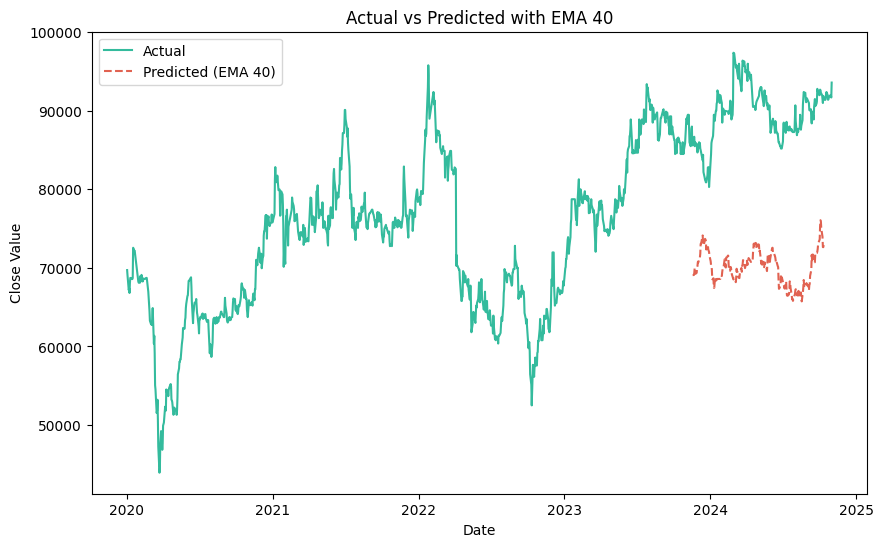

In [184]:
# Chart show result
# Assuming y_pred_rf is the prediction result from the model
# Smooth the predicted data with a 40-period EMA (using either normalized or original data)
y_pred_rf_ema = pd.Series(y_pred_rf).ewm(span=10, adjust=False).mean()
y_pred_rf_sma = pd.Series(y_pred_rf).rolling(window=20).mean()
shifted_index = data_rf_lagged.index[-len(y_pred_rf_sma):] - pd.Timedelta(days=20)
# Plot the chart for actual values and the predicted values smoothed with 40-period EMA
plt.figure(figsize=(10, 6))

# Plot the line for actual values (Close)
plt.plot(data_rf_lagged.index, data_rf_lagged['Close'], label='Actual', color='#34bb9d')

# Plot the line for predicted values smoothed (EMA 40)
plt.plot(shifted_index , y_pred_rf_sma, label='Predicted (EMA 40)', color='#e16251', linestyle='--')

# Add a title and axis labels
plt.title('Actual vs Predicted with EMA 40')
plt.xlabel('Date')
plt.ylabel('Close Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [185]:
# Insight: 

## 2.3 LSTM

### 2.3.1 Exploratory Data Analyst

#### Preparing data

In [186]:
# VNINDEX data
df_VCB_raw= pd.read_csv(r"D:\HK5\STAT\Final\dataset\VCB.csv")
# Rename columns
df_VCB_raw=df_VCB_raw.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_VCB_raw['Date'] = pd.to_datetime(df_VCB_raw['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_VCB_raw['Close'] = pd.to_numeric(df_VCB_raw['Close'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['Open'] = pd.to_numeric(df_VCB_raw['Open'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['High'] = pd.to_numeric(df_VCB_raw['High'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['Low'] = pd.to_numeric(df_VCB_raw['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_VCB_raw['Change %'] = pd.to_numeric(
    df_VCB_raw['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric

# Apply the conversion function to 'Volumne' column
df_VCB_raw['Volumne'] = df_VCB_raw['Volumne'].apply(convert_to_number)

# Display DataFrame info to verify changes
df_VCB_raw.info()
df_VCB_raw = df_VCB_raw.ffill()
df_VCB_raw.set_index('Date', inplace=True)
df_VCB_raw = df_VCB_raw.sort_index(ascending=True)
df_VCB_raw 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1207 non-null   datetime64[ns]
 1   Close     1207 non-null   int64         
 2   Open      1207 non-null   int64         
 3   High      1207 non-null   int64         
 4   Low       1207 non-null   int64         
 5   Volumne   1206 non-null   float64       
 6   Change %  1207 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 66.1 KB


,Close,Open,High,Low,Volumne,Change %
Date,,,,,,
2020-01-02,69728,69267,70189,68883,492910.0,0.67
2020-01-03,69037,70265,70496,69037,684100.0,-0.99
2020-01-06,67194,68499,68730,67194,1120000.0,-2.67
2020-01-07,67424,66810,67501,65581,1290000.0,0.34
2020-01-08,66810,66733,67501,66195,921630.0,-0.91
...,...,...,...,...,...,...
2024-10-25,91800,92100,92300,91700,1050000.0,0.11
2024-10-28,92000,91500,92300,91500,1130000.0,0.22
2024-10-29,92000,92100,92600,92000,1400000.0,0.00


#### Drawing line chart

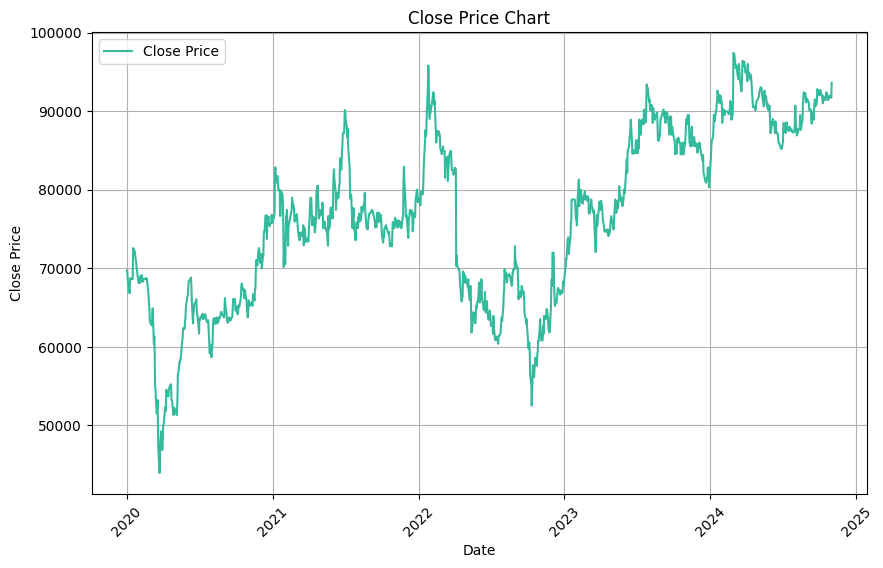

In [187]:
# Line chart for Close price

plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(df_VCB_raw['Close'], label='Close Price', color='#34bb9d')  # Plot the Close prices
plt.title('Close Price Chart')  # Set the title of the chart
plt.xlabel('Date')  # X-axis label
plt.ylabel('Close Price')  # Y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Show gridlines
plt.xticks(rotation=45)  # Rotate X-axis labels if necessary
plt.show()


#### Data preprocessing

In [188]:
# Preprocessing Close Price
data = df_VCB_raw['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

### 2.3.2 Build model

#### Split data

In [189]:
# Time steps
time_step = 60 

# Split the data into sequences
generator = TimeseriesGenerator(scaled_data, scaled_data, length=time_step, batch_size=32)


#### Split into training and testing set

In [190]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Định nghĩa mô hình LSTM
model = Sequential()

# LSTM layer: units = số lượng đơn vị LSTM, input_shape = (time_step, features)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Dropout layer để giảm overfitting
model.add(Dropout(0.2))

# LSTM layer thứ hai (return_sequences=False vì không cần output cho lớp tiếp theo)
model.add(LSTM(units=50, return_sequences=False))

# Dropout layer
model.add(Dropout(0.2))

# Dense layer: để xuất ra một giá trị duy nhất (dự đoán tiếp theo)
model.add(Dense(units=1))

# Compile mô hình với optimizer và loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Xem tóm tắt mô hình
model.summary()
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create datasets for training and testing
X_train, y_train = [], []
X_test, y_test = [], []

for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])  # 60 previous time steps as input data
    y_train.append(train_data[i, 0])             # Predict the next value
    
for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])   # 60 previous time steps as input data
    y_test.append(test_data[i, 0])               # Predict the next value

# Convert data into numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape X_train and X_test to be compatible with LSTM: (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


C:\Users\lyngo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 55, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 55, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

#### Modelling

In [191]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions on the test set
y_pred = model.predict(X_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
# Reverse the scaling to get values back to their original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
# Get the last 20% of the test set (by default from the test data that has already been split)
test_size = int(len(y_test_inv) * 0.2)  # 20% of the test set
y_test_inv_20 = y_test_inv[-test_size:]  # Get the last 20% of the test data
y_pred_inv_20 = y_pred_inv[-test_size:]  # Get the last 20% of the predictions

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0925
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0101
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0067
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0062
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0054
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0056
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0050
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0048
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0049
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0049
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0048
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0043
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0048
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0044
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0051
Epoc

### 2.3.3 Check prediction result

#### Check result

In [192]:
# Calculate MAE, MSE, RMSE, and R^2
mae = mean_absolute_error(y_test_inv, y_pred_inv)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R^2): {r2}')


Mean Absolute Error (MAE): 1572.4915436126373
Mean Squared Error (MSE): 4323211.159382579
Root Mean Squared Error (RMSE): 2079.233310473497
R-squared (R^2): 0.44873056295286007


### 2.3.4 Visualize prediction results

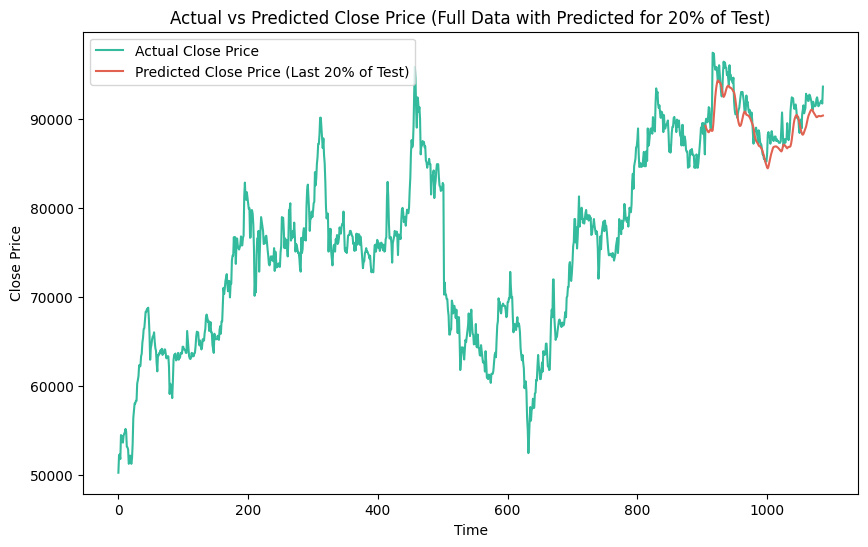

In [193]:
# Plot the entire actual values (y_test_inv + y_train_inv)
# If you have both train and test values, you need to concatenate them before plotting
y_full_inv = np.concatenate((scaler.inverse_transform(y_train.reshape(-1, 1)), y_test_inv), axis=0)

# Get the last 20% of the test set for predictions
test_size = int(len(y_test_inv) * 1)  # 20% of the test set
y_pred_inv_20 = y_pred_inv[-test_size:]  # Get the last 20% of predictions

# Plot the chart
plt.figure(figsize=(10, 6))

# Plot the entire actual values
plt.plot(y_full_inv, color='#34bb9d', label='Actual Close Price')  # Actual values

# Plot the predicted values only for the last 20% of the test set
plt.plot(np.arange(len(y_full_inv)-test_size, len(y_full_inv)), y_pred_inv_20, color='#e16251', label='Predicted Close Price (Last 20% of Test)')

plt.title('Actual vs Predicted Close Price (Full Data with Predicted for 20% of Test)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [194]:
# Calculate MAE, MSE, RMSE, and R^2
mae = mean_absolute_error(y_test_inv, y_pred_inv)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R^2): {r2}')


Mean Absolute Error (MAE): 1572.4915436126373
Mean Squared Error (MSE): 4323211.159382579
Root Mean Squared Error (RMSE): 2079.233310473497
R-squared (R^2): 0.44873056295286007


### 2.3.5 Apply model and predict data for 10 days

#### Prediction

In [195]:
# Use the last 60 days of the test data to predict the next 10 days
last_60_days = X_test[-1]  # Get the last 60 days from X_test

# Predict values for the next 10 days
predicted_prices = []

for _ in range(10):  # Predict the next 10 days
    pred = model.predict(last_60_days.reshape(1, time_step, 1))  # Predict for the next day
    predicted_prices.append(pred[0, 0])  # Append the prediction to the list

    # Update the input data for the next prediction
    last_60_days = np.append(last_60_days[1:], pred, axis=0)  # Append the prediction to the end of the sequence

# Reverse the scaling to get actual values
predicted_prices_inv = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Print the predicted prices for the next 10 days
print("Predicted Prices for the next 10 days:")
print(predicted_prices_inv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Prices for the next 10 days:
[[90354.8  ]
 [90230.766]
 [90031.68 ]
 [89785.04 ]
 [89508.56 ]
 [89213.85 ]
 [88908.484]
 [88597.46 ]
 [88284.09 ]
 [87970.625]]


## 2.4 RESEMBLE 2 Model

#### 2.4.1 Preparing data

In [196]:
# Combine the training and testing predictions into one array
combined_pred = np.vstack([train_pred, test_pred])

# Create a DataFrame from the combined array, with column name 'pred'
df = pd.DataFrame(combined_pred, columns=['pred'])

# Get the last date from df_VCB_raw
end_date = df_VCB_raw.index[-1]

# Adjust the index of df to match the number of rows and end at the last date of df_VCB_raw
df.index = df_VCB_raw.index[-len(df):]
data_rf_lagged_filtered = data_rf_lagged[data_rf_lagged.index.isin(df.index)]
result = df.join(data_rf_lagged_filtered, lsuffix='_df', rsuffix='_lagged')
result

,pred,Close,GDP,Inflation,Unemployment_rate,Rate,Close_lag_270,SMA_100,SMA_200,SMA_50,EMA_50,RSI_14
Date,,,,,,,,,,,,
2020-06-30,49171.328125,61665,2.865413,3.220934,2.103,2.30,67073.370695,59631.96,76441.384707,61084.14,62410.528431,38.763140
2020-07-01,49391.406250,63508,2.865413,3.220934,2.103,2.78,67073.370695,59575.90,76441.384707,61250.02,62453.566532,48.226580
2020-07-02,49845.632812,63431,2.865413,3.220934,2.103,2.78,67073.370695,59527.52,76441.384707,61420.50,62491.897256,47.893565
2020-07-03,50430.035156,63738,2.865413,3.220934,2.103,2.78,67073.370695,59479.91,76441.384707,61630.92,62540.764030,49.393980
2020-07-06,51020.179688,63661,2.865413,3.220934,2.103,2.78,67073.370695,59429.99,76441.384707,61841.32,62584.694853,49.012768
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25,90278.851562,91800,6.500000,4.022000,1.500,4.46,87800.000000,89338.60,90670.800000,91141.00,91009.582352,52.756894
2024-10-28,90278.976562,92000,6.500000,4.022000,1.500,4.46,88000.000000,89368.60,90699.800000,91229.00,91048.422260,54.565868
2024-10-29,90304.109375,92000,6.500000,4.022000,1.500,4.46,87500.000000,89403.60,90725.800000,91307.00,91085.739034,54.565868


### 2.4.2 Build Model

In [197]:
# Build model
# Assume data_rf_lagged is your DataFrame with lagged variables
X = result[['Rate', 'GDP', 'Inflation', 'Unemployment_rate', 'SMA_200', 'SMA_100', 'SMA_50', 'EMA_50', 'RSI_14','pred']] 
y = result['Close_lag_270']  # Dependent variable

# Standardize the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model with optimized parameters
rf_model = RandomForestRegressor(
    n_estimators=200,      # Number of trees
    max_depth=None,         # No limit on the depth of the trees
    max_features='sqrt',    # Select the smallest number of features at each split
    min_samples_leaf=1,     # Minimum of 4 samples in each leaf
    min_samples_split=2,    # Minimum of 2 samples to split a node
    random_state=42         # Ensure reproducibility
)
rf_model.fit(X_train, y_train)
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation results
print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - R-squared:", r2_rf)
y_pred_rf += 18000

Random Forest - Mean Squared Error: 1286039.1116056226
Random Forest - R-squared: 0.984170895916879


### 2.4.3 Visualize result

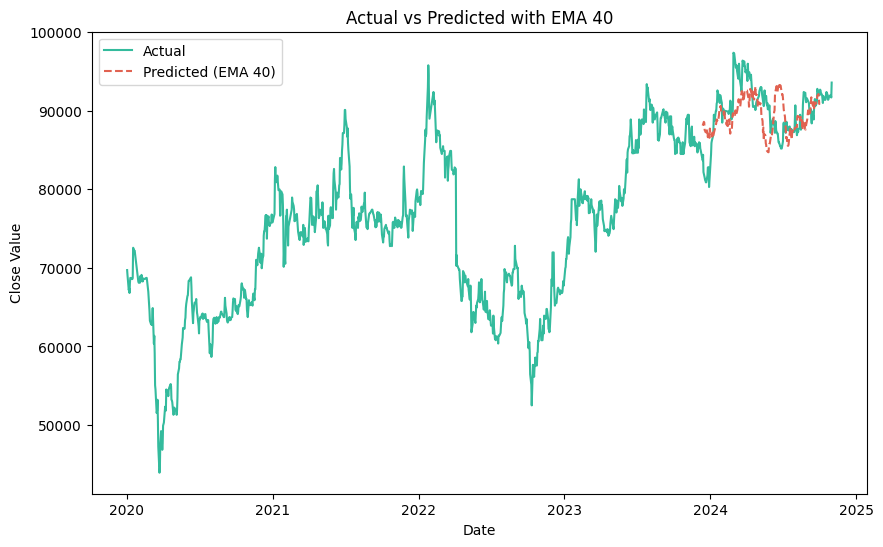

In [198]:
# Chart show result
# Assuming y_pred_rf is the prediction result from the model
# Smooth the predicted data with a 40-period EMA (using either normalized or original data)
y_pred_rf_ema = pd.Series(y_pred_rf).ewm(span=10, adjust=False).mean()
y_pred_rf_sma = pd.Series(y_pred_rf).rolling(window=20).mean()
shifted_index = data_rf_lagged.index[-len(y_pred_rf_sma):] - pd.Timedelta(days=30)
# Plot the chart for actual values and the predicted values smoothed with 40-period EMA
plt.figure(figsize=(10, 6))

# Plot the line for actual values (Close)
plt.plot(data_rf_lagged.index, data_rf_lagged['Close'], label='Actual', color='#34bb9d')

# Plot the line for predicted values smoothed (EMA 40)
plt.plot(shifted_index , y_pred_rf_sma, label='Predicted (EMA 40)', color='#e16251', linestyle='--')

# Add a title and axis labels
plt.title('Actual vs Predicted with EMA 40')
plt.xlabel('Date')
plt.ylabel('Close Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()
